<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
#Sean Grube IBM AI Engineer Coursera Capstone
#September 2022
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

loan_train.csv: Permission denied


### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - seaborn


The following packages will be UPDATED:

  conda              pkgs/main::conda-4.11.0-py39haa95532_0 --> anaconda::conda-4.13.0-py39haa95532_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                         pkgs/main --> anaconda
  seaborn                                         pkgs/main --> anaconda


Preparing transaction: ...working... done
Verifying transaction: ...working... failed




==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




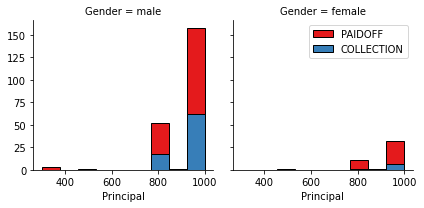

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

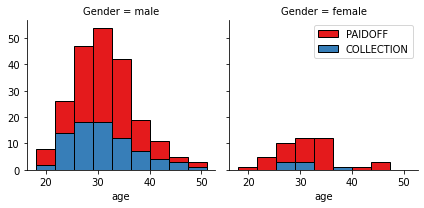

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


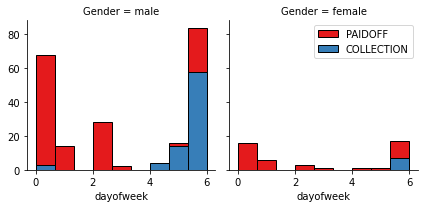

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
#one hot encode loan_status for SVM
#Feature = pd.concat([Feature,pd.get_dummies(df['loan_status'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


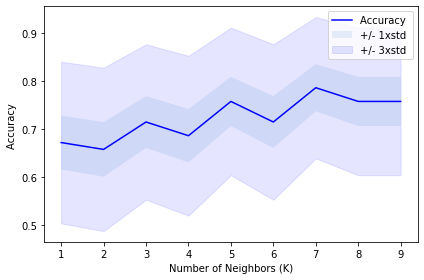

The best accuracy was with 0.7857142857142857 with k= 7
Train set Accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Iterate through the training set to find which number of neighbors (k) yields highest accuracy
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc
plt.plot(range(1,Ks),mean_acc,'b')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="blue")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

#Change k= to highest accuracy in chart. In this instance, 7 yields 80% test set accuracy.
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

In [22]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.7766540244416351

In [23]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,average='weighted')

0.6627869897959183

Sean Grube note: K = 7 yields the highest test set accuracy (80%)

# Decision Tree


In [24]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import sys
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

from sklearn.model_selection import train_test_split
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

#Display the trainigng and test set 
print('Shape of X Training Set {}'.format(X_trainset.shape),'&','Size of Y Training Set {}'.format(y_trainset.shape))
print('Shape of X Test Set {}'.format(X_testset.shape),'&','Size of Y Test Set {}'.format(y_testset.shape))
decTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
decTree # it shows the default parameters
decTree.fit(X_trainset,y_trainset)

Shape of X Training Set (242, 8) & Size of Y Training Set (242,)
Shape of X Test Set (104, 8) & Size of Y Test Set (104,)


DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [25]:
#Compare the predictions to the actual values
predTree = decTree.predict(X_testset)
print ('Prediction:', predTree [0:5])
print ('Test Set:', y_testset [0:5])

Prediction: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Test Set: ['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF']


DecisionTrees's Accuracy:  0.6538461538461539


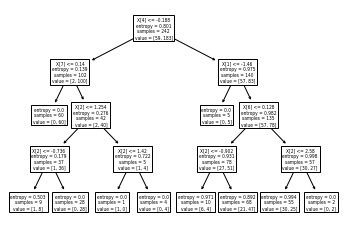

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt
#Provide the accuracy
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))
#Visualize the tree
tree.plot_tree(decTree)
plt.show()

In [27]:
#f1 Score
from sklearn.metrics import f1_score
f1_score(y_testset, predTree, average='weighted')

0.6666949930317142

In [28]:
#Jaccard Score
from sklearn.metrics import jaccard_score
jaccard_score(y_testset, predTree, average='weighted')

0.5163627581209999

Sean Grube Note: DecisionTrees Accuracy is 65.38%

# Support Vector Machine


In [29]:
SVMdf = df
SVMdf.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

In [30]:
SVMdf.groupby(['education'])['loan_status'].value_counts(normalize=True)


education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

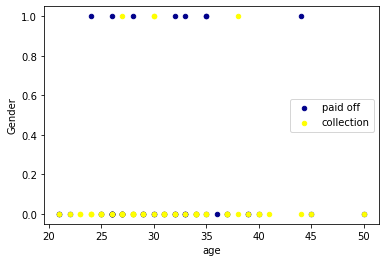

In [31]:
#I need to make all columns an integer and drop those I don't care about
#importantly I need loan_status to be 0 or 1, I will use 1 as COLLECTION and 0 as PAIDOFF
SVMdf['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[2,4],inplace=True)
SVMdf['loan_status'].value_counts()

ax = SVMdf[SVMdf['loan_status'] == 2][0:50].plot(kind='scatter', x='age', y='Gender', color='DarkBlue', label='paid off');
SVMdf[SVMdf['loan_status'] == 4][0:50].plot(kind='scatter', x='age', y='Gender', color='Yellow', label='collection', ax=ax);
plt.show()

In [32]:
SVMdf = pd.concat([SVMdf,pd.get_dummies(df['education'])], axis=1)
SVMdf

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,2,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0,1,0,0
1,2,2,2,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,1,0,0,0
2,3,3,2,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,0,0,0,1
3,4,4,2,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0,0,0,1
4,6,6,2,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,4,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1,0,1,0,0
342,395,395,4,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1,0,1,0,0
343,397,397,4,800,15,2016-09-12,2016-09-26,39,college,0,0,0,0,0,0,1
344,398,398,4,1000,30,2016-09-12,2016-11-10,28,college,0,0,0,0,0,0,1


In [33]:
SVMdf.head()
#SVMdf.dtypes
SVMdf = SVMdf[pd.to_numeric(SVMdf['loan_status'], errors='coerce').notnull()]
SVMdf['loan_status'] = SVMdf['loan_status'].astype('int')
SVMdf.dtypes


Unnamed: 0                       int64
Unnamed: 0.1                     int64
loan_status                      int32
Principal                        int64
terms                            int64
effective_date          datetime64[ns]
due_date                datetime64[ns]
age                              int64
education                       object
Gender                           int64
dayofweek                        int64
weekend                          int64
Bechalor                         uint8
High School or Below             uint8
Master or Above                  uint8
college                          uint8
dtype: object

In [34]:
SVMdf['loan_status'].value_counts()

2    260
4     86
Name: loan_status, dtype: int64

In [35]:
SVMdf['loan_status'].astype('int')
SVMdf

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,2,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0,1,0,0
1,2,2,2,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,1,0,0,0
2,3,3,2,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,0,0,0,1
3,4,4,2,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0,0,0,1
4,6,6,2,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,4,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1,0,1,0,0
342,395,395,4,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1,0,1,0,0
343,397,397,4,800,15,2016-09-12,2016-09-26,39,college,0,0,0,0,0,0,1
344,398,398,4,1000,30,2016-09-12,2016-11-10,28,college,0,0,0,0,0,0,1


In [36]:
SVMfeature = SVMdf[['Principal', 'terms', 'age', 'Gender', 'college']]
#could add in 
svmX = np.asarray(SVMfeature)
svmX[0:5]



array([[1000,   30,   45,    0,    0],
       [1000,   30,   33,    1,    0],
       [1000,   15,   27,    0,    1],
       [1000,   30,   28,    1,    1],
       [1000,   30,   29,    0,    1]], dtype=int64)

In [37]:
SVMfeature.head()

,Principal,terms,age,Gender,college
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,1
3,1000,30,28,1,1
4,1000,30,29,0,1


In [38]:
SVMdf

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,2,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0,1,0,0
1,2,2,2,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,1,0,0,0
2,3,3,2,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,0,0,0,1
3,4,4,2,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0,0,0,1
4,6,6,2,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,4,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1,0,1,0,0
342,395,395,4,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1,0,1,0,0
343,397,397,4,800,15,2016-09-12,2016-09-26,39,college,0,0,0,0,0,0,1
344,398,398,4,1000,30,2016-09-12,2016-11-10,28,college,0,0,0,0,0,0,1


In [39]:
SVMdf['loan_status'] = SVMdf['loan_status'].astype('int')

In [40]:
SVMdf

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,0,0,2,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0,0,1,0,0
1,2,2,2,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0,1,0,0,0
2,3,3,2,1000,15,2016-09-08,2016-09-22,27,college,0,3,0,0,0,0,1
3,4,4,2,1000,30,2016-09-09,2016-10-08,28,college,1,4,1,0,0,0,1
4,6,6,2,1000,30,2016-09-09,2016-10-08,29,college,0,4,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,4,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1,0,1,0,0
342,395,395,4,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1,0,1,0,0
343,397,397,4,800,15,2016-09-12,2016-09-26,39,college,0,0,0,0,0,0,1
344,398,398,4,1000,30,2016-09-12,2016-11-10,28,college,0,0,0,0,0,0,1


In [41]:
#Predict value of loan_status field
svmy = np.asarray(SVMdf['loan_status'])
svmy [:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [42]:
#Train/Test dataset
X_train, X_test, y_train, y_test = train_test_split(svmX, svmy, test_size=0.3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 5) (242,)
Test set: (104, 5) (104,)


In [43]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

svmyhat = clf.predict(X_test)
svmyhat [:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [44]:
#evaluation
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

              precision    recall  f1-score   support

           2       0.78      1.00      0.88        81
           4       0.00      0.00      0.00        23

    accuracy                           0.78       104
   macro avg       0.39      0.50      0.44       104
weighted avg       0.61      0.78      0.68       104

Confusion matrix, without normalization
[[81  0]
 [23  0]]


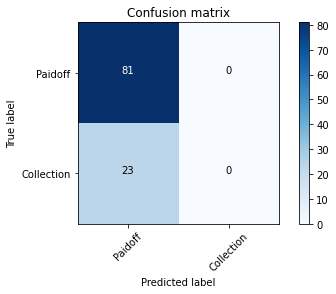

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, svmyhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, svmyhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paidoff','Collection'],normalize= False,  title='Confusion matrix')

In [46]:
#f1 score
from sklearn.metrics import f1_score
f1_score(y_test, svmyhat, average='weighted')

0.682016632016632

In [47]:
#jaccard
from sklearn.metrics import jaccard_score
jaccard_score(y_test, svmyhat,pos_label=2)

0.7788461538461539

# Logistic Regression


In [48]:
lrdf = SVMdf
lrdf = lrdf[['loan_status', 'Principal', 'terms', 'age', 'Gender', 'college']]
lrdf['loan_status'] = lrdf['loan_status'].astype('int')
lrdf.head()

,loan_status,Principal,terms,age,Gender,college
0,2,1000,30,45,0,0
1,2,1000,30,33,1,0
2,2,1000,15,27,0,1
3,2,1000,30,28,1,1
4,2,1000,30,29,0,1


In [49]:
X = np.asarray(lrdf[['Principal', 'terms', 'age', 'Gender', 'college']])
X[0:5]


array([[1000,   30,   45,    0,    0],
       [1000,   30,   33,    1,    0],
       [1000,   15,   27,    0,    1],
       [1000,   30,   28,    1,    1],
       [1000,   30,   29,    0,    1]], dtype=int64)

In [50]:
y = np.asarray(lrdf['loan_status'])
y [:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [51]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -0.87],
       [ 0.52, -0.96, -0.65, -0.42,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  1.15]])

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [54]:
yhat = LR.predict(X_test)
yhat

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [55]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.57, 0.43],
       [0.62, 0.38],
       [0.6 , 0.4 ],
       [0.55, 0.45],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.58, 0.42],
       [0.59, 0.41],
       [0.55, 0.45],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.57, 0.43],
       [0.68, 0.32],
       [0.56, 0.44],
       [0.64, 0.36],
       [0.66, 0.34],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.63, 0.37],
       [0.57, 0.43],
       [0.56, 0.44],
       [0.61, 0.39],
       [0.67, 0.33],
       [0.56, 0.44],
       [0.56, 0.44],
       [0.71, 0.29],
       [0.56, 0.44],
       [0.67, 0.33],
       [0.6 , 0.4 ],
       [0.61, 0.39],
       [0.61, 0.39],
       [0.58, 0.42],
       [0.68, 0.32],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.62, 0.38],
       [0.62, 0.38],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.58, 0.42],
       [0.62, 0.38],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.56, 0.44],
       [0.6 , 0.4 ],
       [0.57,

In [56]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.7857142857142857

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[2,4]))

[[55  0]
 [15  0]]


Confusion matrix, without normalization
[[55  0]
 [15  0]]


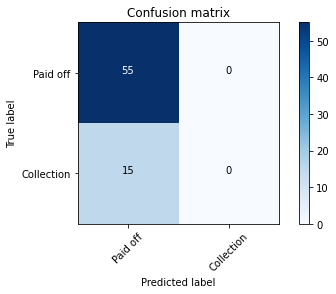

In [58]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid off','Collection'],normalize=False,  title='Confusion matrix')

In [59]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       0.79      1.00      0.88        55
           4       0.00      0.00      0.00        15

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



In [60]:
#jaccard score for logistic regression
jaccard_score(y_test, yhat,pos_label=2)

0.7857142857142857

In [61]:
#F1 score for logistic regression
f1_score(y_test, yhat, average='weighted')

0.6914285714285714

In [62]:
#Log Loss for logistic regression
from sklearn.metrics import log_loss
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob2))

LogLoss: : 0.53


# Model Evaluation using Test set


In [63]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [64]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-09-15 07:00:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 21.9M=0s

2022-09-15 07:00:51 (21.9 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation


In [65]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [66]:

'''"
 ** REPORT **

F1   JACCARD   and LOG LOSS scores 
are located at the bottom of each section

 ** Thank You! **
 
'''

'"\n ** REPORT **\n\nF1   JACCARD   and LOG LOSS scores \nare located at the bottom of each section\n\n ** Thank You! **\n \n'

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:



| Algorithm        | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.66    | 0.78     | NA      |
| Decision Tree      | 0.52    | 0.67     | NA      |
| SVM                | 0.78    | 0.68     | NA      |
| LogisticRegression | 0.79    | 0.69     | 0.53    |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
